# Test CIFAR10 modeling code

In [1]:
import sys
import json

import torch
import torchvision
from pytorch_lightning import Trainer

import cifar10
from cifar10 import utils

sys.path.insert(0,'./src')
import main
import inference

## Test PTL model implementation

In [2]:
model = cifar10.MyNet()
data  = cifar10.MyDataModule(data_dir='/tmp/pytorch-example/cifar-10-data')

trainer = Trainer(gpus=1, max_epochs=1)
trainer.fit(model, data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Extracting /tmp/pytorch-example/cifar-10-data/cifar-10-python.tar.gz to /tmp/pytorch-example/cifar-10-data
Setting up a super-fresh new model.



  | Name      | Type             | Params
-----------------------------------------------
0 | conv1     | Conv2d           | 456   
1 | pool      | MaxPool2d        | 0     
2 | conv2     | Conv2d           | 2 K   
3 | fc1       | Linear           | 48 K  
4 | drop1     | Dropout          | 0     
5 | fc2       | Linear           | 10 K  
6 | drop2     | Dropout          | 0     
7 | fc3       | Linear           | 850   
8 | criterion | CrossEntropyLoss | 0     
/opt/conda/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/opt/conda/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

## Test model saver in `main.py`

In [3]:
main._save_model(trainer, '/tmp/pytorch-example/', './src/')

## Check files
Make sure images and checkpoints are where you expect them to be

In [4]:
! ls /tmp/pytorch-example
! ls /tmp/pytorch-example/code

cifar-10-data  code  model.ckpt
inference.py


Peak at some pictures to make sure they make sense

GroundTruth:  frog truck truck deer


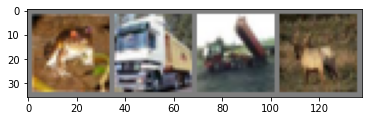

In [5]:
trainloader = data.train_dataloader()
testloader  = data.val_dataloader()

# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
n_show = min(4, data.batch_size)
utils.imshow(torchvision.utils.make_grid(images[:n_show]))
print('GroundTruth: ', ' '.join('%4s' % utils.classes[labels[j]] for j in range(n_show)))


## Test model loader
Check that loaded model makes identical predictions

In [6]:
new_model = main.model_fn('/tmp/pytorch-example/')

Setting up a super-fresh new model.


In [7]:
model.eval()
new_model.eval()

MyNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [8]:
torch.norm( model(images) - new_model(images), p=2 )

tensor(0., grad_fn=<NormBackward0>)

## Run additional epoch of training
Make sure model weights don't reset, and that we get new predictions

In [ ]:
new_model.train()
trainer.fit(new_model, data)


  | Name      | Type             | Params
-----------------------------------------------
0 | conv1     | Conv2d           | 456   
1 | pool      | MaxPool2d        | 0     
2 | conv2     | Conv2d           | 2 K   
3 | fc1       | Linear           | 48 K  
4 | drop1     | Dropout          | 0     
5 | fc2       | Linear           | 10 K  
6 | drop2     | Dropout          | 0     
7 | fc3       | Linear           | 850   
8 | criterion | CrossEntropyLoss | 0     


A model has already been setup.


In [ ]:
new_model.cpu()
new_model.eval()

In [ ]:
torch.norm( model(images) - new_model(images), p=2 )

## Test `inference.py` code
Request will be made as a json dumped to a `str`.

In [ ]:
request = json.dumps( {'images': images.numpy().tolist()} )

input_data = inference.input_fn(request)
predictions= inference.predict_fn(input_data, new_model)
output_data, _ = inference.output_fn(predictions)